# KRAS_Pt2_TmTc

___
Import the required libraries.
___

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB and branch == "stable":
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import loompy

Global seed set to 0


___
Set the filepath to store the results.
___

In [2]:
results_folder = '/data/xy/Spatial_transcriptome/eWEIDE/20240326_public_Yeyouqiong/other_methods/cell2location/result/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}reference_signatures'
run_name = f'{results_folder}cell2location_map'

raw_data_path = f'/data/xy/Spatial_transcriptome/eWEIDE/20240326_public_Yeyouqiong/other_methods/scanpy_data/'

image_path = '/data/xy/Spatial_transcriptome/Kras_data/RowSpatialData/KRAS_Pt2_TmTc/outs/'

data_name = 'KRAS_Pt2_TmTc'

Spatial transcriptome data preprocess.

In [3]:
# adata_vis = sc.read_visium(image_path)
# adata_vis
adata_vis = sc.read_h5ad(f"{raw_data_path}/{data_name}_scanpy_Spatial.h5ad")
adata_vis_imageref = sc.read_visium(image_path)
adata_vis.uns['spatial'] = adata_vis_imageref.uns['spatial']
adata_vis

/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1949 × 36601
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.7', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'seurat_clusters', 'annotation', 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'SYMBOL'
    uns: 'spatial'
    obsm: 'X_tsne', 'X_umap'

In [4]:
# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None

In [5]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

Single cell data process

In [6]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

In [7]:
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:20]

,B,CD4 Tm,CD4 Tn,CD8 Tem,CD8 Tex,CD8 Trm,Endothelium,Epithelium c1,FAP+ Myofib,FN1+ Mac,Fibroblast,Glial,IGF1+ Mac,ILC,LEFTY1+ Epithelium c2,MUC2+ Epithelium c4,Mast,Monocyte,NK,Neutrophil
SAMD11,0.000796,0.000616,0.000947,0.001102,0.001386,0.000464,0.034115,0.002706,1.193596,0.003429,0.843271,0.046739,0.004782,0.058917,0.005343,0.003240,0.001002,0.007931,0.001671,0.010785
NOC2L,0.227154,0.147411,0.142433,0.125952,0.163759,0.147466,0.458858,0.102042,0.669450,0.517270,0.267722,0.155132,0.458273,0.181449,1.264672,0.570942,0.097934,0.233551,0.187271,0.012305
AL645608.8,0.000737,0.004481,0.001753,0.003357,0.001963,0.008988,0.150928,0.002101,0.358522,0.582985,0.020071,0.016127,0.388914,0.023649,0.323191,0.079065,0.036401,0.167310,0.011233,0.040454
HES4,0.082049,0.185213,0.175913,0.059405,0.053068,0.224715,1.603931,0.065834,3.633283,2.851134,0.468183,0.237199,3.479853,0.575704,2.313904,0.814208,0.602695,2.624946,0.178845,1.455942
ISG15,0.369623,0.596210,0.366554,0.614252,0.856221,0.758612,3.550113,0.249679,6.027821,9.521201,0.857391,1.147360,3.911092,0.903910,2.472436,0.478036,0.294167,3.909303,0.635686,0.416469


In [8]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis.var_names = adata_vis.var['SYMBOL'].copy()
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
intersect

/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:896: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


array(['A1BG', 'A1BG-AS1', 'A1CF', ..., 'ZYG11B', 'ZYX', 'ZZEF1'],
      dtype=object)

In [9]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
intersect
adata_vis[:, intersect]


View of AnnData object with n_obs × n_vars = 1949 × 15655
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.7', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'seurat_clusters', 'annotation', 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'SYMBOL', 'MT_gene'
    uns: 'spatial'
    obsm: 'X_tsne', 'X_umap', 'MT'

In [10]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [11]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
)

mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 1949  │
│          n_vars          │ 15655 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ KRAS_Pt2_TmTc │          0          │
└─────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/xy/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30000/30000: 100%|██████████| 30000/30000 [56:13<00:00,  8.89it/s, v_num=1, elbo_train=1.46e+7]  


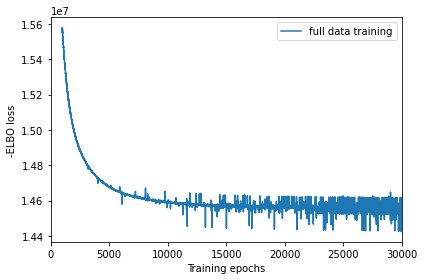

In [12]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [13]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:25<00:00, 39.37it/s]


'/data/xy/Spatial_transcriptome/eWEIDE/20240326_public_Yeyouqiong/other_methods/cell2location/result/cell2location_map/sp.h5ad'

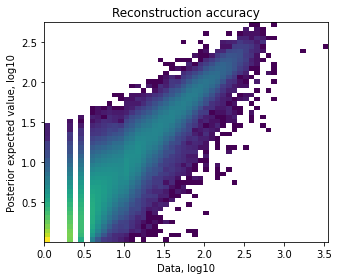

In [14]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [15]:
adata_vis.obs

,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.1,SCT_snn_res.0.2,SCT_snn_res.0.3,SCT_snn_res.0.4,SCT_snn_res.0.5,...,SCT_snn_res.1,seurat_clusters,annotation,in_tissue,array_row,array_col,sample,_indices,_scvi_batch,_scvi_labels
AAACAAGTATCTCCCA-1,0,276.0,220,5710.0,1475,1,0,0,0,0,...,2,2,5,1,50,102,KRAS_Pt2_TmTc,0,0,0
AAACACCAATAACTGC-1,0,8796.0,2841,7755.0,2834,1,0,0,0,0,...,2,2,5,1,59,19,KRAS_Pt2_TmTc,1,0,0
AAACAGAGCGACTCCT-1,0,5346.0,2327,6555.0,2327,0,1,1,1,1,...,1,1,4,1,14,94,KRAS_Pt2_TmTc,2,0,0
AAACATTTCCCGGATT-1,0,6696.0,2492,6982.0,2488,2,2,2,2,2,...,0,0,1,1,61,97,KRAS_Pt2_TmTc,3,0,0
AAACCGTTCGTCCAGG-1,0,3153.0,1683,6604.0,1800,1,0,0,0,0,...,9,9,5,1,52,42,KRAS_Pt2_TmTc,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGTTTCCCGAAAG-1,0,11502.0,3377,8098.0,3291,1,5,5,6,7,...,11,11,5,1,51,59,KRAS_Pt2_TmTc,1944,0,0
TTGTTAGCAAATTCGA-1,0,19580.0,4784,8171.0,3646,0,1,1,1,1,...,1,1,4,1,22,42,KRAS_Pt2_TmTc,1945,0,0
TTGTTCTAGATACGCT-1,0,3240.0,1599,6548.0,1680,0,4,4,4,4,...,4,4,3,1,21,3,KRAS_Pt2_TmTc,1946,0,0
TTGTTTCACATCCAGG-1,0,12912.0,4101,8160.0,3915,2,2,2,2,2,...,0,0,1,1,58,42,KRAS_Pt2_TmTc,1947,0,0


In [16]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
outdf = adata_vis.obs[adata_vis.uns['mod']['factor_names']]
outdf.to_csv(f"{results_folder}/{data_name}_C2L.csv")